In [163]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [164]:
path_to_model = '/content/coco_yolo3.h5'
model = load_model(path_to_model)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [179]:
img_path = '/content/img3.jpeg'
img_org = load_img(img_path, target_size=(416, 416))  # Resize to the model's input size
img = img_to_array(img_org)  # Convert to a NumPy array
img = np.expand_dims(img, axis=0)  # Add batch dimension (1, 320, 320, 3)
img = img / 255.0  # Normalize if required by the model

In [172]:
predictions = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [173]:
predictions[0].shape, predictions[1].shape, predictions[2].shape

((1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255))

In [174]:
# List of labels used for classification
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]


anchors = [
    [(116, 90), (156, 198), (373, 326)],  # Large scale (13x13)
    [(30, 61), (62, 45), (59, 119)],     # Medium scale (26x26)
    [(10, 13), (16, 30), (33, 23)]       # Small scale  (52x52)
]

input_dim = 416
confidence_threshold = 0.5

In [175]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def decode_predictions(predictions, anchors, input_dim, confidence_threshold=0.5):
    boxes, scores, classes = [], [], []
    for scale, anchor_set in zip(predictions, anchors):
        grid_size = scale.shape[1]
        num_anchors = len(anchor_set)
        num_classes = scale.shape[-1] // num_anchors - 5

        # Reshape to (batch_size, grid, grid, anchors, attributes)
        scale = scale.reshape((scale.shape[0], grid_size, grid_size, num_anchors, 5 + num_classes))

        # Extract values
        box_xy = sigmoid(scale[..., :2])  # x, y (sigmoid)
        box_wh = np.exp(scale[..., 2:4])  # width, height (exp)
        box_confidence = sigmoid(scale[..., 4:5])  # confidence (sigmoid)
        class_probs = sigmoid(scale[..., 5:])  # class probabilities (sigmoid)

        # Compute box corners
        grid = np.arange(grid_size)
        grid_x, grid_y = np.meshgrid(grid, grid)
        box_xy += np.stack((grid_x, grid_y), axis=-1)[..., np.newaxis, :]  # Adjust for grid
        box_xy /= grid_size
        box_wh /= input_dim
        box_coords = np.concatenate((box_xy, box_wh), axis=-1)

        # Flatten results
        box_coords = box_coords.reshape(-1, 4)
        box_scores = (box_confidence * class_probs).reshape(-1, num_classes)
        max_scores = np.max(box_scores, axis=-1)
        max_classes = np.argmax(box_scores, axis=-1)

        # Apply confidence threshold
        mask = max_scores > confidence_threshold
        boxes.append(box_coords[mask])
        scores.append(max_scores[mask])
        classes.append(max_classes[mask])

    # Combine all scales
    return np.concatenate(boxes), np.concatenate(scores), np.concatenate(classes)



boxes, scores, classes = decode_predictions(predictions, anchors, input_dim, confidence_threshold)

In [176]:
def apply_nms(boxes, scores, classes, iou_threshold=0.8, max_boxes=50):
    # Perform non-max supression
    indices = tf.image.non_max_suppression(
        boxes, scores, max_boxes, iou_threshold
    )
    # Filter the elements
    filtered_boxes = tf.gather(boxes, indices)
    filtered_scores = tf.gather(scores, indices)
    filtered_classes = tf.gather(classes, indices)
    return filtered_boxes.numpy(), filtered_scores.numpy(), filtered_classes.numpy()

boxes, scores, classes = apply_nms(boxes, scores, classes)

In [177]:
def draw_boxes(image, boxes, scores, classes, labels):
    # image = cv2.imread(image_path)
    # height, width = image.shape[:2]
    image = img[0]
    height, width = 416, 416

    # Scale boxes back to the original image size
    for box, score, cls in zip(boxes, scores, classes):
        x, y, w, h = box
        left = int((x - w / 2) * width)
        top = int((y - h / 2) * height)
        right = int((x + w / 2) * width)
        bottom = int((y + h / 2) * height)

        # Draw the bounding box
        cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)

        # Add the label
        label = f"{labels[cls]}: {score:.2f}"
        cv2.putText(image, label, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Show the image with bounding boxes
    return image




processed_image = draw_boxes(image, boxes, scores, classes, labels)


(-0.5, 415.5, 415.5, -0.5)

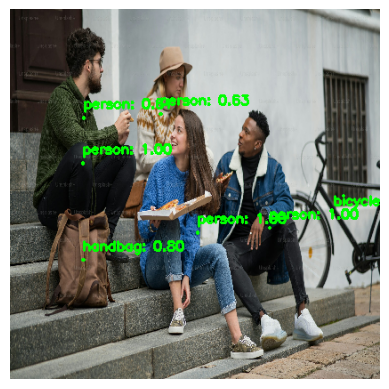

In [178]:
# processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
plt.imshow(processed_image)
plt.axis('off')